# Machine Learning Techniques - MISIS4219

## Taller 6

Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

**Integrante 1:**

**Integrante 2:**

**NOTA:**  El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller6.ipynb

In [15]:
!pip install -q yfinance
!pip install pandas_datareader

## Objetivo: Predecir los próximos valores de cierre de stocks de compañías, dado el registro histórico de estas

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Para leer los datos de Yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# para settear tiempos
from datetime import datetime

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Dataset: Para este problema usaremos la librería yfinance, la cual retorna los valores de stock para diferentes empresas, en este caso tenemos los valores de APPLE - AAPL, GOOGLE - GOOG, Microsoft _ MSFT, Amazon - AMZN

Como ejemplo solamente usamos los registros de 1 año, para el taller cambiar el codigo para ver los registros de los ultimos **3 años**

In [17]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

#Asignamos el rango de fechas en las que queremos consultar los datos
end = datetime.now() #fecha actual
start = datetime(end.year - 3, end.month, end.day) #Fecha de hace un año

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-04-08,186.899994,187.289993,184.809998,185.190002,185.190002,39221300,AMAZON
2024-04-09,187.240005,187.339996,184.199997,185.669998,185.669998,36546900,AMAZON
2024-04-10,182.770004,186.270004,182.669998,185.949997,185.949997,35879200,AMAZON
2024-04-11,186.740005,189.770004,185.509995,189.050003,189.050003,40020700,AMAZON
2024-04-12,187.720001,188.380005,185.080002,186.130005,186.130005,38554300,AMAZON
2024-04-15,187.429993,188.690002,183.000000,183.619995,183.619995,48052400,AMAZON
2024-04-16,183.270004,184.830002,182.259995,183.320007,183.320007,32891300,AMAZON
2024-04-17,184.309998,184.570007,179.820007,181.279999,181.279999,31359700,AMAZON
2024-04-18,181.470001,182.389999,178.649994,179.220001,179.220001,30723800,AMAZON


# Seleccionar los datos de una de las compañías previamente ejecutadas y obtener los valores de stock de cierre (Close o Adj close)

In [19]:
df_apple = df[df['company_name'] == 'APPLE']
df_apple = df_apple.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], axis=1)
df_apple.tail(10)

,Close,company_name
Date,,
2024-04-08,168.449997,APPLE
2024-04-09,169.669998,APPLE
2024-04-10,167.779999,APPLE
2024-04-11,175.039993,APPLE
2024-04-12,176.550003,APPLE
2024-04-15,172.690002,APPLE
2024-04-16,169.380005,APPLE
2024-04-17,168.000000,APPLE
2024-04-18,167.039993,APPLE


## Graficar la variación de los precios de salida a lo largo del tiempo seleccionado

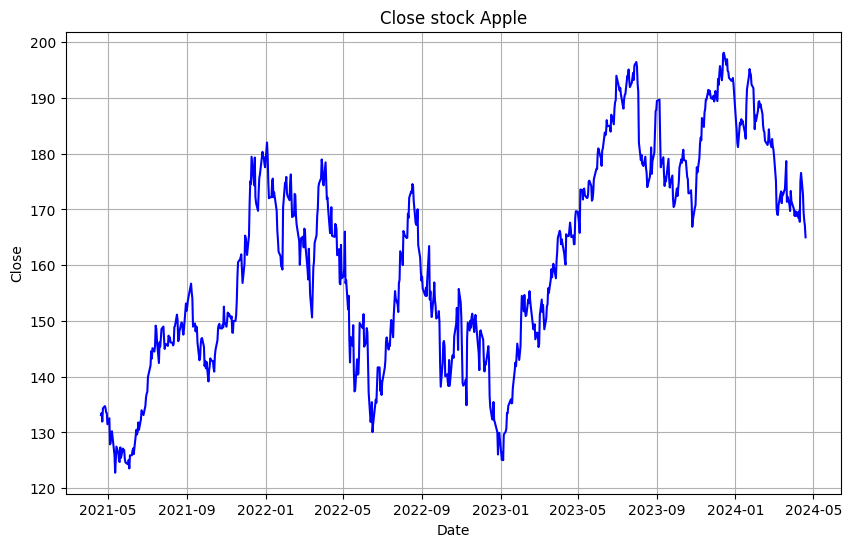

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df_apple.index, df_apple['Close'], color='blue', linestyle='-')
plt.title('Close stock Apple')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.show()

## Tomar el 60% de los datos para entrenar 20% para validación y 20% para test

In [21]:
raw_data = df_apple['Close'].values #nota: usar .values para convertirlo en un array de numpy
num_train_samples = int(0.6 * len(raw_data)) #60% de los datos
num_val_samples = int(0.2 * len(raw_data)) #20% de los datos
num_test_samples = len(raw_data) - num_train_samples - num_val_samples #los datos restantes
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 453
num_val_samples: 151
num_test_samples: 152


In [22]:
# Estandarizacion de los datos. primero restamos los valores por la media y luego se dividen por
# la desviación estandar
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


## Dividir los datos en X y Y.
Aquí realizamos en ejemplo con el entrenamiento. **Elaborar los datos para el test y validación**

In [23]:
# dividir los en x_train y y_train

train_data = raw_data[:num_train_samples]
valid_data = raw_data[:num_val_samples]
test_data = raw_data[:num_test_samples]
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

sequence_length = 60

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i]) #obtenemos los datos de la secuencia 0-59
    y_train.append(train_data[i]) #el dato 60 se convierte en el target
    if i<= 61:
        print(x_train)
        print(y_train)

for i in range(sequence_length, len(valid_data)):
    x_val.append(valid_data[i-sequence_length:i]) #obtenemos los datos de la secuencia 0-59
    y_val.append(valid_data[i]) #el dato 60 se convierte en el target
    if i<= 61:
        print(x_val)
        print(y_val)

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i]) #obtenemos los datos de la secuencia 0-59
    y_test.append(test_data[i]) #el dato 60 se convierte en el target
    if i<= 61:
        print(x_test)
        print(y_test)

# Convertimos x_train y y_train en arrays de numpy
x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

[array([-1.21986061, -1.19245222, -1.30208577, -1.13482371, -1.10671293,
       -1.12990481, -1.18682984, -1.19385808, -1.33581893, -1.2599196 ,
       -1.58952321, -1.57195316, -1.45669723, -1.42366647, -1.65980124,
       -1.72586223, -1.94653574, -1.79192375, -1.61763453, -1.70056263,
       -1.8003573 , -1.81160151, -1.62747341, -1.75959592, -1.64223173,
       -1.65628712, -1.65980124, -1.77013773, -1.81722388, -1.84041576,
       -1.78559898, -1.89242136, -1.72726809, -1.72656516, -1.66753187,
       -1.64012348, -1.71180683, -1.62466222, -1.40469217, -1.46372546,
       -1.42788405, -1.31262812, -1.40609696, -1.27678564, -1.15871906,
       -1.17839682, -1.19877698, -1.21986061, -1.10249642, -0.99356525,
       -0.94928975, -0.92750373, -0.73845565, -0.59368308, -0.41447388,
       -0.50794379, -0.37652421, -0.41939386, -0.33927694, -0.09260143])]
[-0.13968758689221966]
[array([-1.21986061, -1.19245222, -1.30208577, -1.13482371, -1.10671293,
       -1.12990481, -1.18682984, -1.1

In [24]:
x_train.shape

(393, 60)

Para crear nuestro dataset de entrenamiento, prueba y validación usaremos la función 'timeseries_dataset_from_array'.

La idea general es que al proporcionar una matriz de datos de series temporales (el argumento de datos), timeseries_dataset_from_array
te da ventanas extraídas de la serie temporal original.

Por ejemplo, supomgamos que nuestros datos son: [0 1 2 3 4 5 6] y sequence_length=3, entonces timeseries_dataset_from_array generará las siguientes muestras: [0 1 2], [2 3 4], [3 4 5], [4 5 6].

Usaremos la función timeseries_dataset_from_array para inicializar tres datasets: uno para entrenamiento, otro para prueba y otro para validación:


* sequence_length : Longitud de las secuencias de salida (en número de pasos de tiempo).


Documentación: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array


In [25]:
import numpy as np
from tensorflow import keras

batch_size = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
                    x_train,
                    targets=y_train,
                    sequence_length=sequence_length,
                    shuffle=True,
                    batch_size=batch_size)

val_dataset = keras.utils.timeseries_dataset_from_array(
                    x_val,
                    targets=y_val,
                    sequence_length=sequence_length,
                    shuffle=True,
                    batch_size=batch_size)

test_dataset = keras.utils.timeseries_dataset_from_array(
                    x_test,
                    targets=y_test,
                    sequence_length=sequence_length,
                    shuffle=True,
                    batch_size=batch_size)

2024-04-20 01:37:40.701085: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-20 01:37:40.701123: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-20 01:37:40.701139: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-20 01:37:40.701424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 01:37:40.701479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
for samples, target in train_dataset:
  print(f'sample shape: {samples.shape}, target shape: {target.shape}')

sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (14, 60, 60), target shape: (14,)


2024-04-20 01:37:40.947279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Crear Modelo

In [27]:
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val_reshaped = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
print(x_train.shape)

model = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(sequence_length, x_train_reshaped.shape[2])),
    keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')  # mse: Error cuadrático medio para regresión

(393, 60)


/Users/willy/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
epochs = 50
batch_size = 32

model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=(x_val_reshaped, y_val))

Epoch 1/50


2024-04-20 01:37:41.223154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [ ]:
model.summary()

# Evaluación del modelo

In [ ]:
loss = model.evaluate(x_test_reshaped, y_test)

In [ ]:
predictions = model.predict(x_test)

# Calcular MSE
mse = mean_squared_error(y_test, predictions)

# Calcular MAE
mae = mean_absolute_error(y_test, predictions)

# Calcular R^2
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

## Graficar resultados

In [ ]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicciones', color='blue')
plt.plot(y_test, label='Valores reales', color='red')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Valores reales')
plt.legend()
plt.show()